# Instruction to lab work # 2: "Playing with a binary cross-entropy loss & calculating backpropagation"

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Tasks of the work

0. Set your student id number and used it as random seed for getting unique values to you.
1. Select a few (2 or more) data entries, most comfortable to you (from list of proposed ones or create own kernel for this).
2. Review available activation functions (available 1).
3. Review available loss functions (available 1).
4. Read and understand theory from the theoretical section.

## Experiments with single activation function (one decision boundary)

5. Using the selected data entry and activation function set weights (random ones)
6. Use example experiments as template and step by step conduct own experiments.
7. Use for each experiment different starting points `w1`, `w2`, `b` and different `learning_rate`s observe how influence various starting points on the training process.
8. Task*: investigate own loss function (create own derivative for that function) and do calculus. For example you can use MAE (mean absolute error), MSE (mean squared error), RMSE (root mean squared error) etc.
9. Task**: think & realize combination of a few "neurons" in your solution.


In [1]:
STUDENT_ID = 23

# Code part
## Import dependencies

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Help functions

## 1. Kernel functions for data generation.

In [3]:
def gaussian_kernel(center):
    """Factory for a kernel that generates a blob of points."""

    # The returned function takes n_points and generates them around the specified center.
    return lambda n: np.repeat(np.array([center]), n, axis=0)


def circle_kernel(radius, start_angle=0, end_angle=2 * np.pi):
    """Factory for a kernel that generates points on a circle or arc."""

    def _kernel(n):
        theta = np.linspace(start_angle, end_angle, n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T

    return _kernel


def spiral_kernel(rotations=1.5, start_radius=1.0):
    """Factory for a kernel that generates points in a spiral."""

    def _kernel(n):
        theta = np.linspace(0, rotations * 2 * np.pi, n)
        radius = np.linspace(start_radius, start_radius + (rotations * 2), n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T

    return _kernel


def sine_wave_kernel(amplitude=1, frequency=1, x_range=(-5, 5)):
    """Factory for a kernel that generates points along a sine wave."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.sin(frequency * x)
        return np.vstack([x, y]).T

    return _kernel


def tanh_wave_kernel(amplitude=1, stretch=1, x_range=(-5, 5)):
    """Factory for a kernel that generates points along a tanh (S-shaped) curve."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.tanh(stretch * x)
        return np.vstack([x, y]).T

    return _kernel


def exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 2)):
    """Factory for a kernel that generates points along an exponential curve."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * (base ** x)
        return np.vstack([x, y]).T

    return _kernel


def logarithmic_kernel(amplitude=1, x_range=(0.1, 5)):
    """Factory for a kernel that generates points along a logarithmic curve."""
    if x_range[0] <= 0:
        raise ValueError("The start of x_range for the logarithmic kernel must be > 0.")

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.log(x)
        return np.vstack([x, y]).T

    return _kernel

## 2. Activation functions (decision boundary functions)

!!! WARNING !!! in this lab work we using sigmoid activation function cause it has scope [0, 1] and it works with current function activation.

But you can use any manual function activation with your manually crafted loss function (feel free to experiment with that)

In [4]:
def sigmoid_activation(w1, w2, x1, x2, b):
    """
    Sigmoid activation function.
    :param w1: weight for adjusting x1
    :param w2: weight for adjusting x2
    :param x1: 
    :param x2: 
    :param b: bias
    :return: value in [0, 1] scope
    """
    
    z = w1 * x1 + w2 * x2 + b
    return 1 / (1 + np.exp(-z))

In [5]:
def sigmoid_boundary(w1, w2, b, k=0.5):
    """
    Factory for a sigmoid activation boundary.
    The boundary is where the output is k, so we subtract k from the score.
    This function used for the visualization purpose.
    """
    
    def _boundary(x1, x2):
        z = w1 * x1 + w2 * x2 + b
        return 1 / (1 + np.exp(-z)) - k

    return _boundary

## 3. Loss function (binary cross-entropy)

Equation for binary cross-entropy:
$$
Loss = - \frac{1}{N} \sum_{i=1}^{N} [y_i * log(y^*_i) + (1-y_i) * log(1 - y^*_i)]
$$
, where:
 
* $ N $ - number of samples
* $ y_i $ - probability of correct class (in case of binary problem 0 for 0-th class and 1 for 1-st class)
* $ y^*_i $ - collected value of class probability (by your neural network or any other kind of NN)

In [6]:
def binary_cross_entropy(y_true, y_pred):
    """
    Calculates the binary cross-entropy loss.

    @paramy_true (np.ndarray): Array of true labels (0s and 1s).
        y_pred (np.ndarray): Array of predicted probabilities (between 0 and 1).

    Returns:
        float: The calculated binary cross-entropy loss.
    """
    
    # Epsilon is used to prevent log(0) errors.
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate the loss for each sample
    term_0 = (1 - y_true) * np.log(1 - y_pred)
    term_1 = y_true * np.log(y_pred)
    
    # Average the loss over all samples
    loss = -np.mean(term_0 + term_1)
    
    return loss
    

## 4. Data generation code

In [7]:
def generate_classification_data(n_samples=200, kernels=None, kernel_classes=None,
                                 dispersion=0.2, n_outliers=10, random_seed=42):
    """
    Generates 2D, multi-class data using a flexible kernel-based approach.

    :param n_samples: The total number of data points to generate.
    :param kernels: A list of kernel functions. Each function defines a class and should
                    accept 'n' (number of points) and return an array of shape [n, 2].
    :param kernel_classes: A list of integers mapping each kernel to a class label.
                           Its length must match the length of `kernels`. If None, each kernel
                           is assigned a unique class (e.g., [0, 1, 2, ...]).
    :param dispersion: The standard deviation of Gaussian noise added to each point.
    :param n_outliers: The number of completely random points (noise) to add.
    :param random_seed: A seed for the random number generator for reproducibility.
    :returns: A tuple (X, y) where X is the feature matrix [n_samples, 2]
              and y is the label vector [n_samples,].
    """
    np.random.seed(random_seed)

    if kernels is None:
        kernels = [gaussian_kernel(center=[2, 2]),
                   gaussian_kernel(center=[-2, -2])]

    if kernel_classes is None:
        kernel_classes = list(range(len(kernels)))

    if len(kernels) != len(kernel_classes):
        raise ValueError("The length of 'kernels' and 'kernel_classes' must be the same.")

    n_classes = len(np.unique(kernel_classes))
    n_inliers = n_samples - n_outliers
    if n_inliers <= 0:
        raise ValueError("n_samples must be greater than n_outliers.")

    points_per_kernel = n_inliers // len(kernels)

    X_parts, y_parts = [], []
    for i, kernel in enumerate(kernels):
        class_label = kernel_classes[i]

        # --- THE FIX IS ON THIS LINE ---
        # Ensure the kernel output is float before adding float-based dispersion
        X_class = kernel(points_per_kernel).astype(float)

        X_class += np.random.randn(points_per_kernel, 2) * dispersion
        y_class = np.full(points_per_kernel, class_label)

        X_parts.append(X_class)
        y_parts.append(y_class)

    X_inliers = np.vstack(X_parts)
    y_inliers = np.hstack(y_parts)

    if n_outliers > 0:
        x_min, x_max = X_inliers[:, 0].min(), X_inliers[:, 0].max()
        y_min, y_max = X_inliers[:, 1].min(), X_inliers[:, 1].max()
        padding = (max(x_max - x_min, y_max - y_min)) * 0.1

        X_outliers = np.random.uniform(min(x_min, y_min) - padding,
                                       max(x_max, y_max) + padding,
                                       size=(n_outliers, 2))
        y_outliers = np.random.randint(0, n_classes, size=n_outliers)

        X = np.vstack([X_inliers, X_outliers])
        y = np.hstack([y_inliers, y_outliers])
    else:
        X, y = X_inliers, y_inliers

    permutation = np.random.permutation(X.shape[0])
    X, y = X[permutation], y[permutation]

    return X, y

## 5. Perceptron work visualization

In [8]:
# The combination rule is a logical AND. A point is in the final region
# only if its score is positive for ALL three boundaries.
rule_AND = lambda Z_stack: np.min(Z_stack, axis=0)


def plot_decision_boundary(X, y, decision_functions=None, combination_rule=rule_AND,
                           title="Classification Data", swap_regions=False):
    """
    Plots data and visualizes a complex decision boundary formed by combining multiple functions.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The label vector, shape (n_samples,).
    :param decision_functions: A list of functions, where each takes two arguments (x1, x2) and returns a score.
    :param combination_rule: A function that takes a NumPy array of all function scores and returns a single final score grid.
    :param title: The title for the plot.
    :param swap_regions: If True, swaps the colors of the two decision regions.
    """

    plt.style.use('seaborn-v0_8-pastel')  # Using compatible style name
    fig, ax = plt.subplots(figsize=(8, 8))

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))

    if decision_functions is not None and combination_rule is not None:
        all_Z = np.array([fn(xx1, xx2) for fn in decision_functions])
        final_Z = combination_rule(all_Z)

        # --- THIS IS THE ADDED LOGIC ---
        # If the flag is set, invert the decision scores to swap the regions
        if swap_regions:
            final_Z = -final_Z

        ax.contourf(xx1, xx2, final_Z, levels=[-np.inf, 0, np.inf], colors=['#C4E2FF', '#FFDADA'], alpha=0.6)

        for i, Z in enumerate(all_Z):
            ax.contour(xx1, xx2, Z, levels=[0], colors='gray', linestyles='--', linewidths=1.5)

        ax.contour(xx1, xx2, final_Z, levels=[0], colors='k', linestyles='-', linewidths=2.5)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=0.9, zorder=2)

    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    # --- Corrected Legend Creation ---
    handles, _ = scatter.legend_elements()
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]

    if decision_functions is not None and combination_rule is not None:
        individual_h = plt.Line2D([0], [0], color='gray', linestyle='--', lw=1.5)
        final_h = plt.Line2D([0], [0], color='k', linestyle='-', lw=2.5)
        handles.extend([individual_h, final_h])
        class_labels.extend(['Individual Boundaries', 'Final Boundary'])

    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)

    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    plt.show()

## 6. Examples of generated data

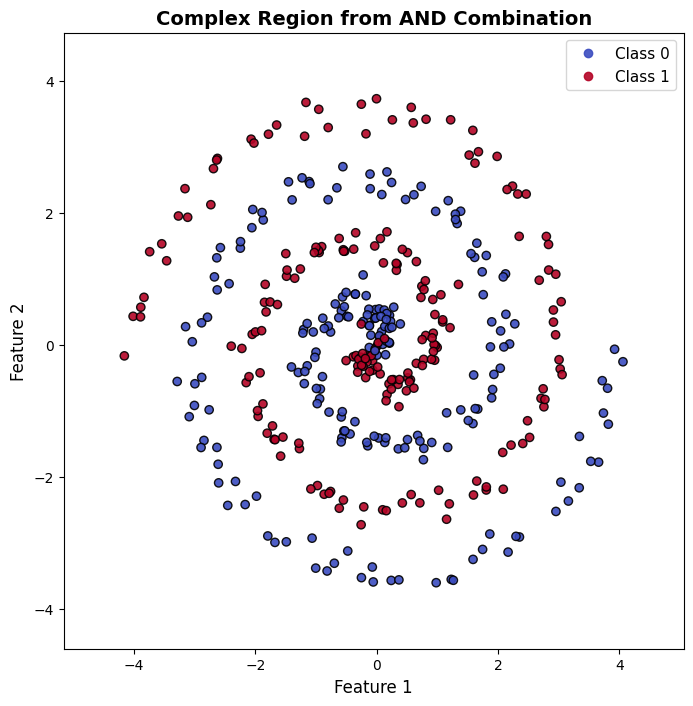

In [9]:
# Spiral data
X_data, y_data = generate_classification_data(
    n_samples=400,
    kernels=[
        spiral_kernel(rotations=2, start_radius=0),
        lambda n: -1 * spiral_kernel(rotations=2, start_radius=0)(n)  # Invert the second spiral
    ],
    kernel_classes=[0, 1],
    dispersion=0.15,
    n_outliers=0,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Complex Region from AND Combination")

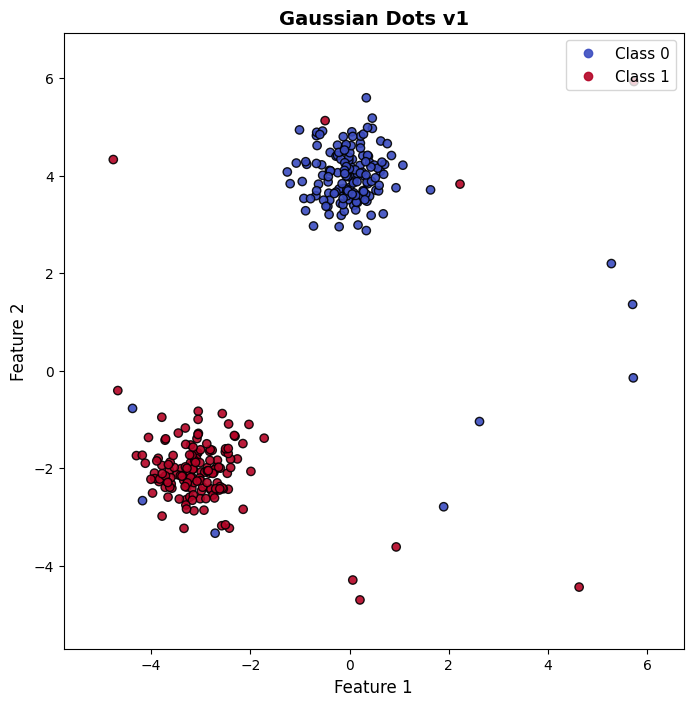

In [10]:
# Gaussian dots data v1
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel(center=[0, 4]),
             gaussian_kernel(center=[-3, -2]), ],
    kernel_classes=[0, 1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=STUDENT_ID,
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Gaussian Dots v1")

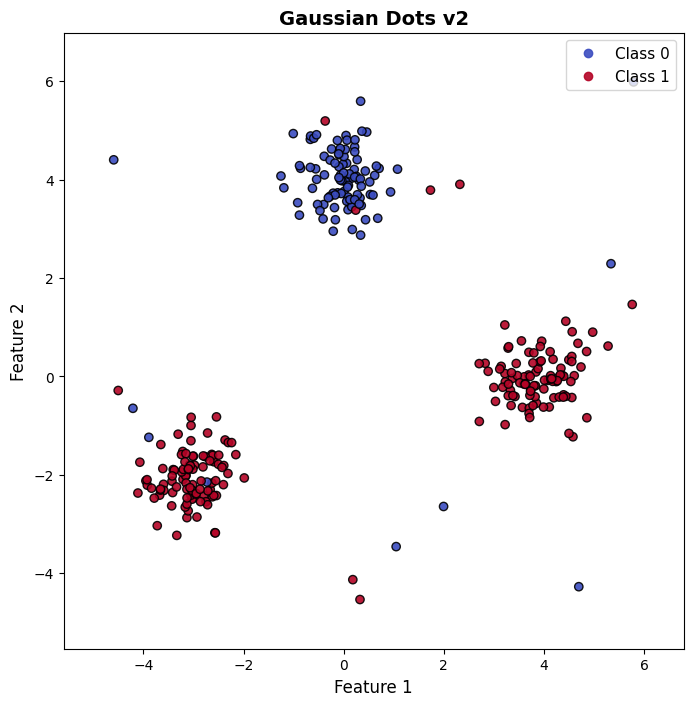

In [11]:
# Gaussian dots data v2
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel(center=[0, 4]),
             gaussian_kernel(center=[-3, -2]),
             gaussian_kernel(center=[4, 0]), ],
    kernel_classes=[0, 1, 1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=STUDENT_ID,
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Gaussian Dots v2")

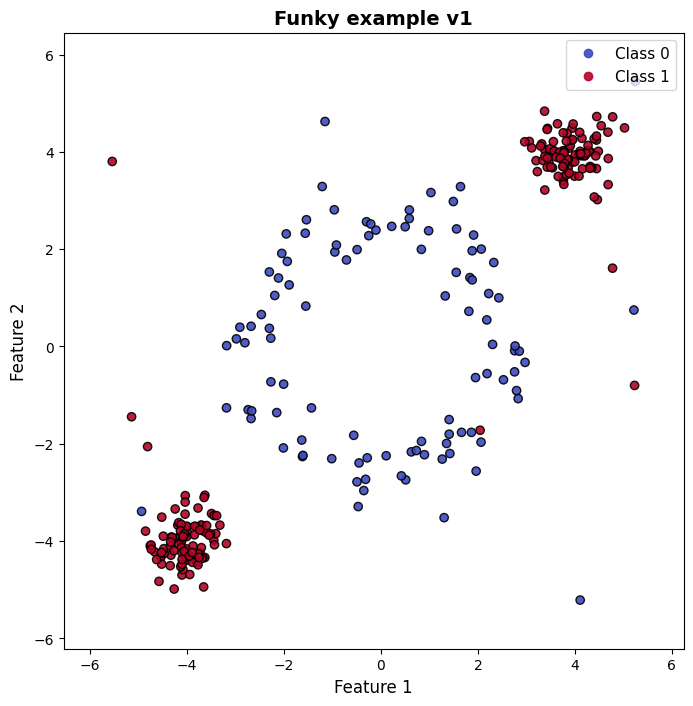

In [12]:
# Funky example v1
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        circle_kernel(radius=2.5),  # This will be for class 0
        gaussian_kernel(center=[-4, -4]),  # This will be part of class 1
        gaussian_kernel(center=[4, 4])  # This will also be part of class 1
    ],
    kernel_classes=[0, 1, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Funky example v1")

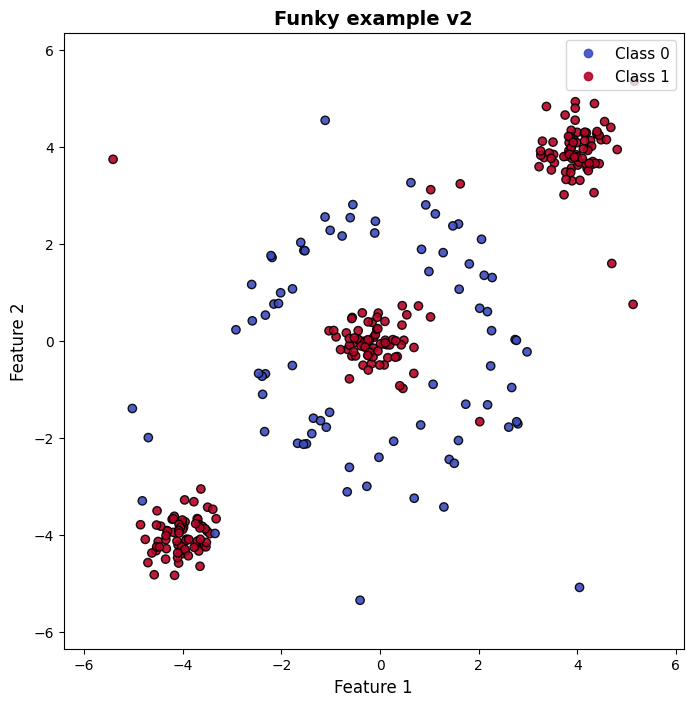

In [13]:
# Funky example v2
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        circle_kernel(radius=2.5),  # This will be for class 0
        gaussian_kernel(center=[-4, -4]),  # This will be part of class 1
        gaussian_kernel(center=[4, 4]),  # This will also be part of class 1
        gaussian_kernel(center=[0, 0]),  # This will also be part of class 1
    ],
    kernel_classes=[0, 1, 1, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Funky example v2")

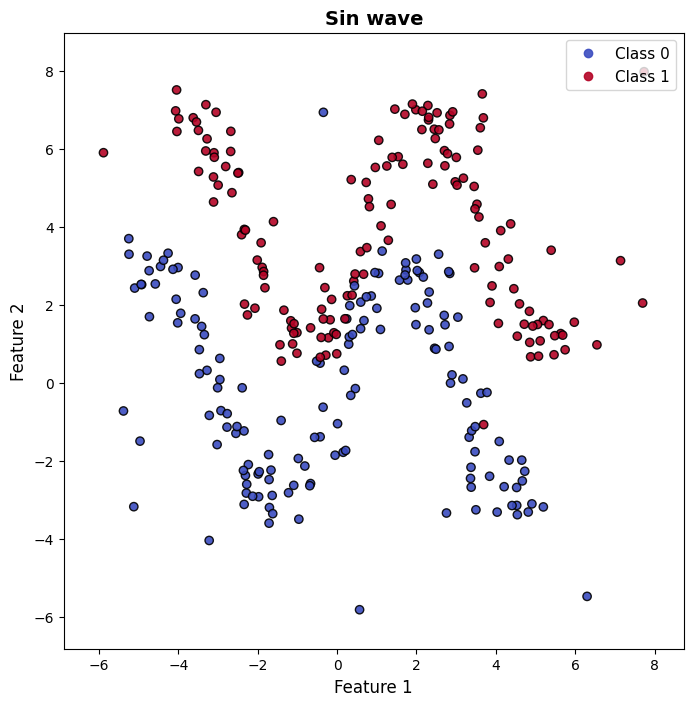

In [14]:
# Sin wave
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        lambda x_: sine_wave_kernel(amplitude=3, frequency=1, x_range=[-5, 5])(x_),
        lambda x_: 4 + sine_wave_kernel(amplitude=-3, frequency=1, x_range=[-8, 2])(x_),
    ],
    kernel_classes=[0, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Sin wave")

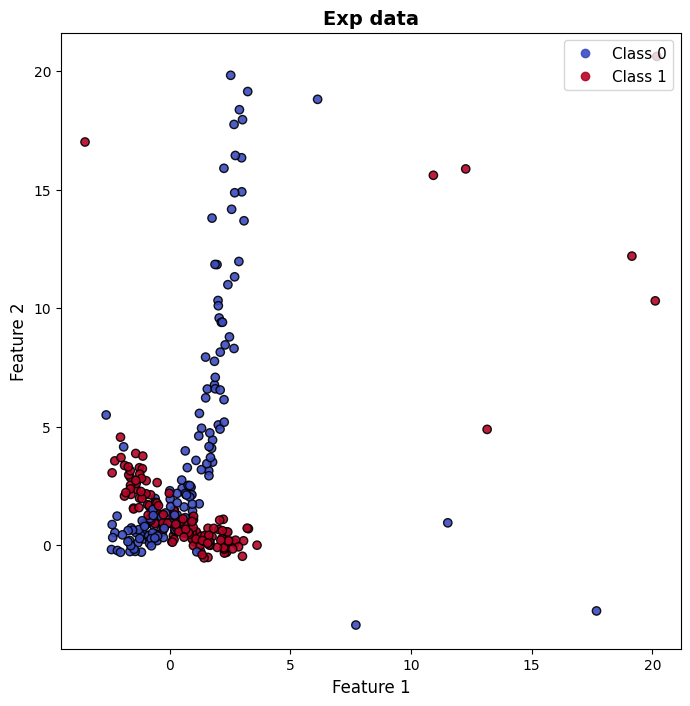

In [15]:
# Exp data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        # Class 0: Exponential growth
        exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 3)),
        # Class 1: Exponential decay
        exponential_kernel(amplitude=1, base=0.5, x_range=(-2, 3))
    ],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Exp data")

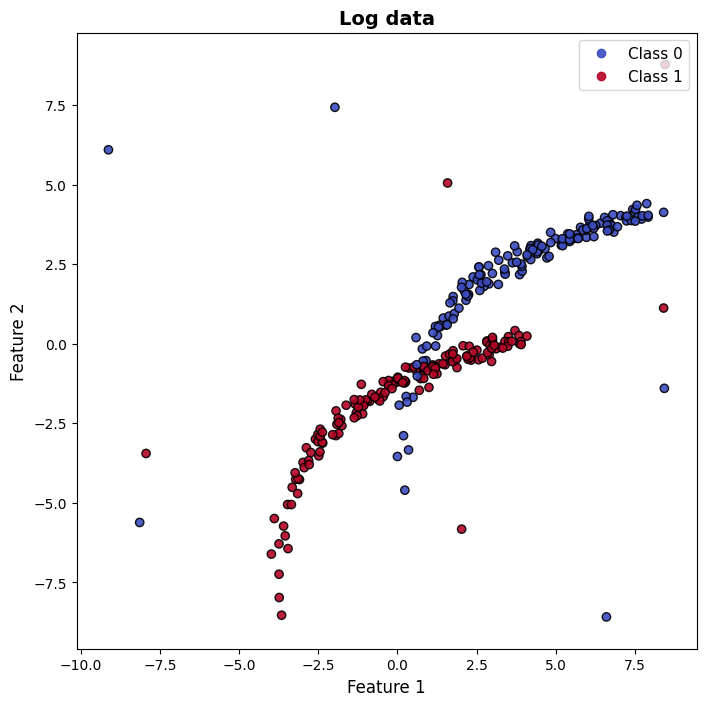

In [16]:
# Logarithmic data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        # Class 0: A standard log curve
        logarithmic_kernel(amplitude=2, x_range=(0.1, 8)),
        # Class 1: Another log curve, shifted down
        lambda n: logarithmic_kernel(amplitude=2, x_range=(0.1, 8))(n) - 4
    ],
    dispersion=0.2,
    n_outliers=10,
    random_seed=STUDENT_ID
)


# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Log data")

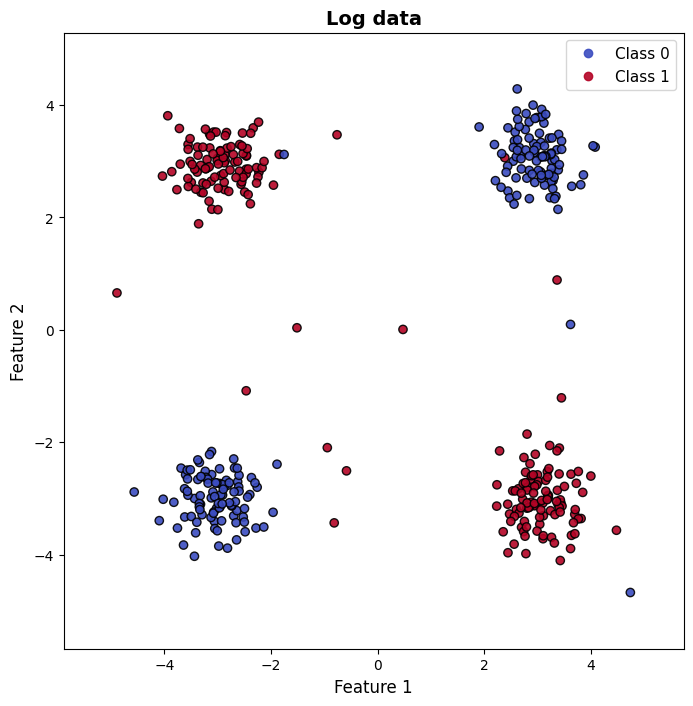

In [17]:
kernels_xor = [
    gaussian_kernel(center=[3, 3]),  # Top-right, Class 0
    gaussian_kernel(center=[-3, -3]),  # Bottom-left, Class 0
    gaussian_kernel(center=[-3, 3]),  # Top-left, Class 1
    gaussian_kernel(center=[3, -3])  # Bottom-right, Class 1
]

# Map the kernels to the two classes
classes_xor = [0, 0, 1, 1]

# Generate and plot the data
X_data, y_data = generate_classification_data(
    n_samples=400,
    kernels=kernels_xor,
    kernel_classes=classes_xor,
    dispersion=0.4,
    n_outliers=20,
    random_seed=101
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Log data")

## 7. Examples of conducting experiment on the selected data & theoretical explanation.

### Theory: How to use backpropagation on a single perceptron?

For a single example $X=(x_1, x_2)$, $y_{true}$ the binary cross-entropy will looks like this: 

$$
Loss = -[y_{true} * log(y_{pred}) + (1 - y_{true}) * log(1 - y_{pred})]
$$

So the idea of backpropagation is to use gradient to find out influence of each weight on the final decision.

And for each weight adjustment temp will look like this:

$$
\frac{\delta L}{\delta w_1} = \frac{\delta L}{\delta y_{pred}} * \frac{\delta y_{pred}}{\delta z} * \frac{\delta z}{\delta w_1}
$$

where $z$ = $x_1 * w_1 + x_2 * w_2 + b$  -- linear sum.

1. For our loss function:

$$
\frac{\delta L}{\delta y_{pred}} = \frac{y_{pred} - y_{true}}{y_{pred}(1 - y_{pred})}
$$

2. For activation to linear sum.

$$
\frac{\delta y_{pred}}{\delta z} = y_{pred} * (1 - y_{pred})
$$

3. For linear sum to weights.

$$
\frac{\delta z}{\delta w_1} = x_1
$$


Using all this updates to weights would be like this:

$$
\triangle w_1 = \frac{\delta L}{\delta w_1} = \frac{y_{pred} - y_{true}}{y_{pred}(1 - y_{pred})} * y_{pred} * (1 - y_{pred}) * x_1
$$

$$
\triangle w_2 = \frac{\delta L}{\delta w_2} = \frac{y_{pred} - y_{true}}{y_{pred}(1 - y_{pred})} * y_{pred} * (1 - y_{pred}) * x_2
$$

$$
\triangle b = \frac{\delta L}{\delta b} = \frac{y_{pred} - y_{true}}{y_{pred}(1 - y_{pred})} * y_{pred} * (1 - y_{pred}) * 1
$$


So adjusted weights to minimize loss value would be:

$$
w_1^{new} = w_1 - a * \triangle w_1
$$

$$
w_2^{new} = w_2 - a * \triangle w_2
$$

$$
b^{new} = b - a * \triangle b
$$


In case of multiple training samples $X = {(x_{1, 1}, x_{1, 2}), (x_{2, 1}, x_{2, 2}), ..., (x_{n, 1}, x_{n, 2})}; y = {y_1, y_2, ..., y_n}$ just sum all weight adjustment to get the final one.

In [28]:
# Logarithmic data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        # Class 0: A standard log curve
        logarithmic_kernel(amplitude=2, x_range=(0.1, 8)),
        # Class 1: Another log curve, shifted down
        lambda n: logarithmic_kernel(amplitude=2, x_range=(0.1, 8))(n) - 4
    ],
    dispersion=0.2,
    n_outliers=10,
    random_seed=STUDENT_ID
)

Binary cross-entropy loss: 6.254937908188569
Weight adjustments: dw1: -55.08409540126157, dw2: 234.9197990559504, db: -141.81768856188904


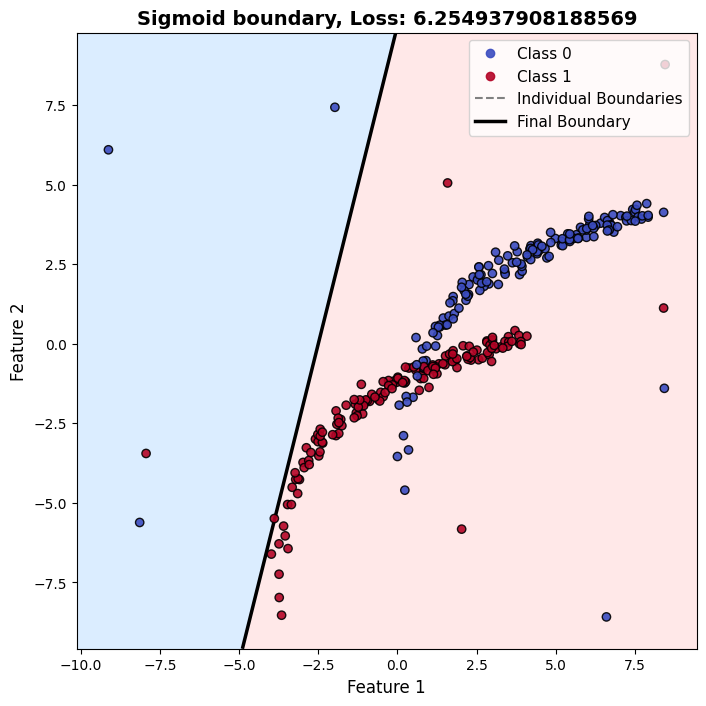

In [52]:
sigmoid_w1 = -4
sigmoid_w2 = 1
sigmoid_b = -10

# Using backpropagation calculate weight adjustment
# Warning (a = y_pred) for simplicity
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [38]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: -2.898318091974769, w2: -3.698395981119008, b: -7.163646228762218


Binary cross-entropy loss: 3.324321114969188
Weight adjustments: dw1: -159.69929365502026, dw2: 1.858516501126977, db: -78.23323132786625


C:\Users\voldo\AppData\Local\Temp\ipykernel_13736\1489877567.py:9: RuntimeWarning: divide by zero encountered in divide
  dL_da = (a - y_data) / (a * (1 - a))


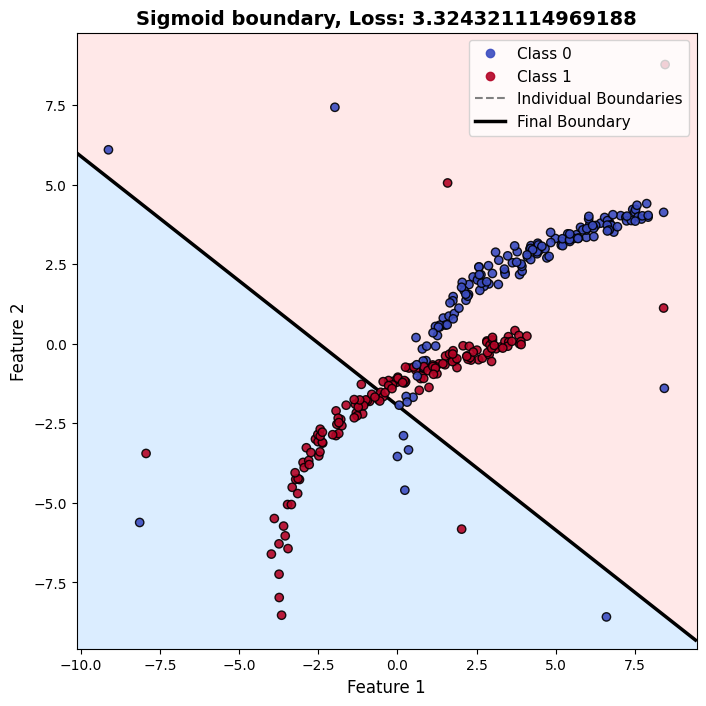

In [39]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [40]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: -1.3013251554245662, w2: -3.7169811461302777, b: -6.381313915483555


Binary cross-entropy loss: 2.33729294542846
Weight adjustments: dw1: -157.23132877478798, dw2: 0.5314006496424453, db: -77.28188525789314


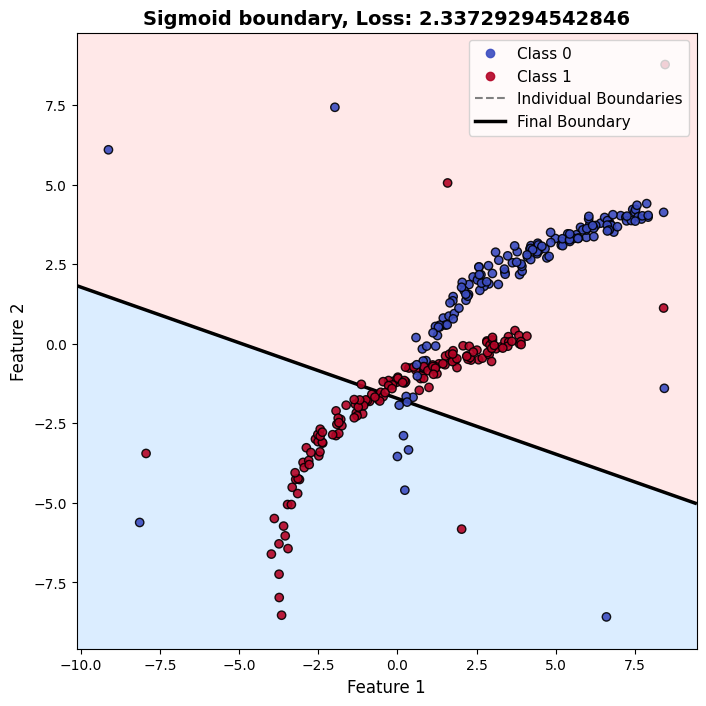

In [41]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [42]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: 0.27098813232331365, w2: -3.7222951526267023, b: -5.608495062904624


Binary cross-entropy loss: 1.3864491096066083
Weight adjustments: dw1: -141.23742513927115, dw2: -1.9231036048137273, db: -73.15588041796578


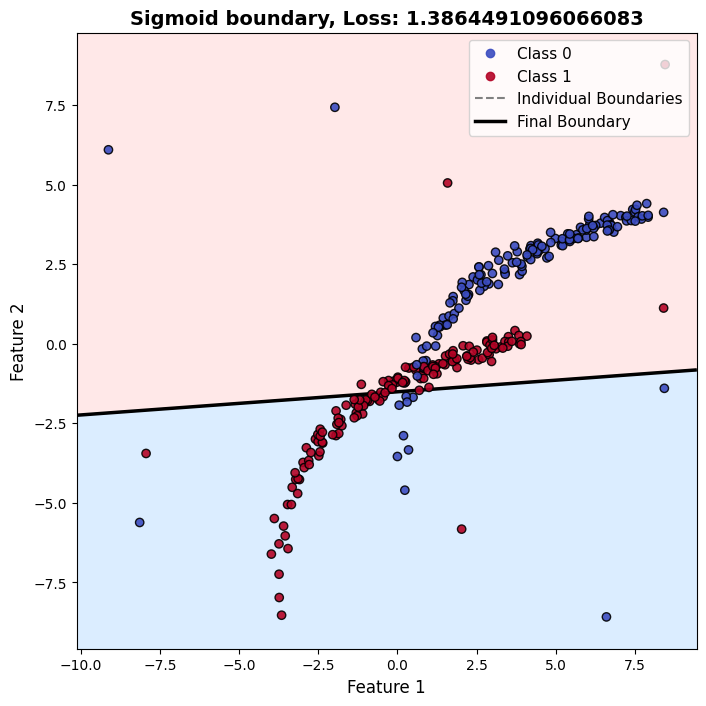

In [43]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [44]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: 1.6833623837160252, w2: -3.703064116578565, b: -4.8769362587249665


Binary cross-entropy loss: 0.7519095773795871
Weight adjustments: dw1: -30.186194330244255, dw2: 2.0547792448174675, db: -42.626878944613885


C:\Users\voldo\AppData\Local\Temp\ipykernel_13736\1489877567.py:9: RuntimeWarning: divide by zero encountered in divide
  dL_da = (a - y_data) / (a * (1 - a))


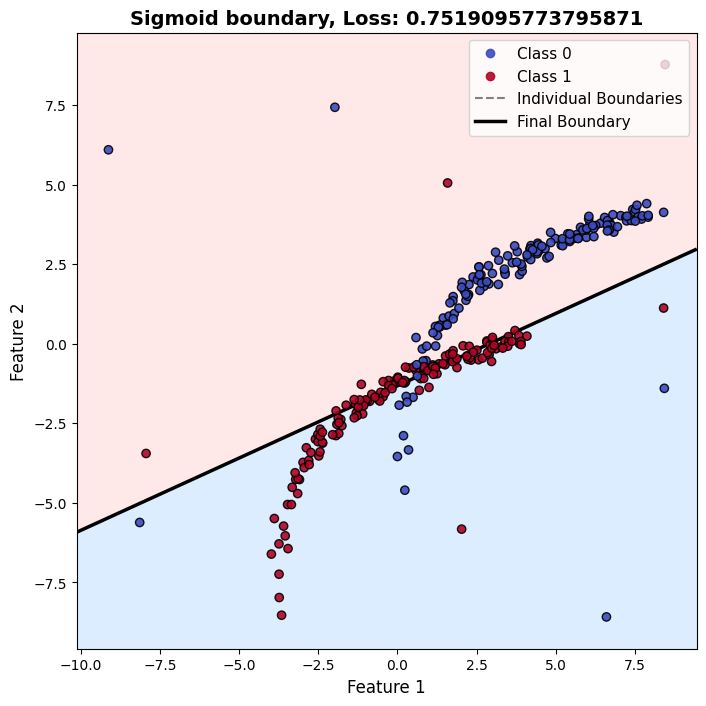

In [45]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [46]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: 1.9852243270184677, w2: -3.7236119090267397, b: -4.4506674692788275


Binary cross-entropy loss: 0.6832967952630271
Weight adjustments: dw1: 6.677908169679165, dw2: -1.1399033523602267, db: -26.446099359283007


C:\Users\voldo\AppData\Local\Temp\ipykernel_13736\1489877567.py:9: RuntimeWarning: divide by zero encountered in divide
  dL_da = (a - y_data) / (a * (1 - a))


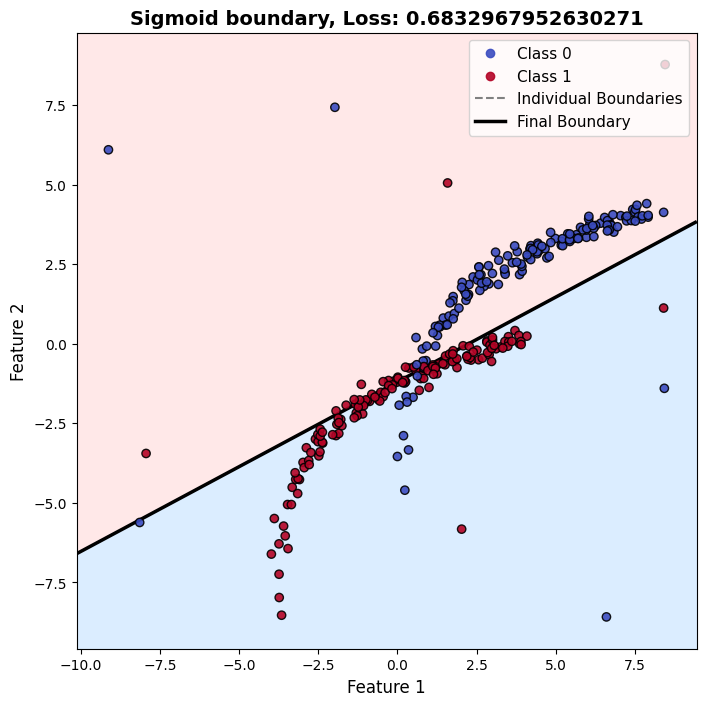

In [47]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [48]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: 1.918445245321676, w2: -3.7122128755031376, b: -4.186206475685998


C:\Users\voldo\AppData\Local\Temp\ipykernel_13736\1489877567.py:9: RuntimeWarning: divide by zero encountered in divide
  dL_da = (a - y_data) / (a * (1 - a))


Binary cross-entropy loss: 0.6619253965328288
Weight adjustments: dw1: 3.4866584271312684, dw2: -9.83350106178975, db: -21.16736465266109


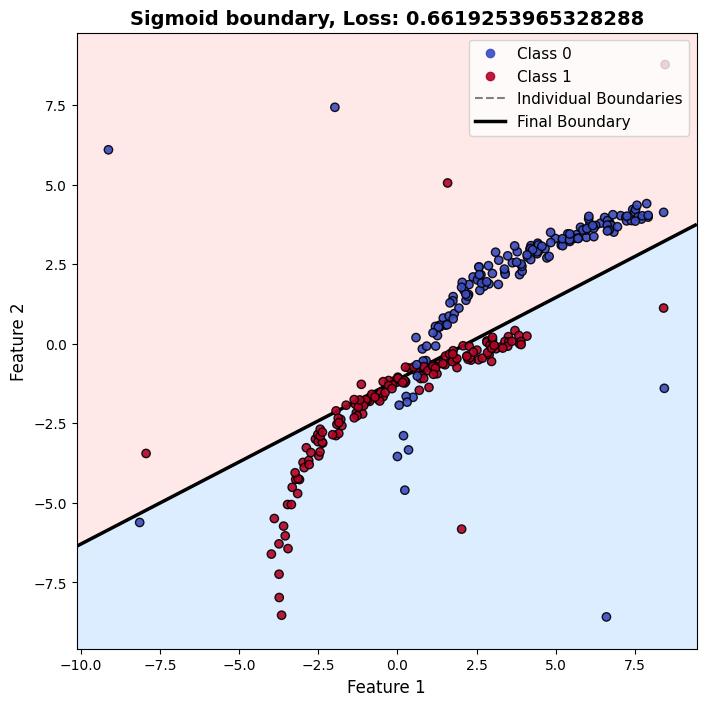

In [49]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

In [50]:
# Update weights: 
learning_rate = 0.01

sigmoid_w1 = sigmoid_w1 - learning_rate * delta_w1
sigmoid_w2 = sigmoid_w2 - learning_rate * delta_w2
sigmoid_b = sigmoid_b - learning_rate * delta_b

print(f"Updated weights: w1: {sigmoid_w1}, w2: {sigmoid_w2}, b: {sigmoid_b}")

Updated weights: w1: 1.8835786610503633, w2: -3.6138778648852403, b: -3.974532829159387


Binary cross-entropy loss: 0.6466862615849223
Weight adjustments: dw1: 6.4333658217147365, dw2: -10.705574971811442, db: -18.985886204880796


C:\Users\voldo\AppData\Local\Temp\ipykernel_13736\1489877567.py:9: RuntimeWarning: divide by zero encountered in divide
  dL_da = (a - y_data) / (a * (1 - a))


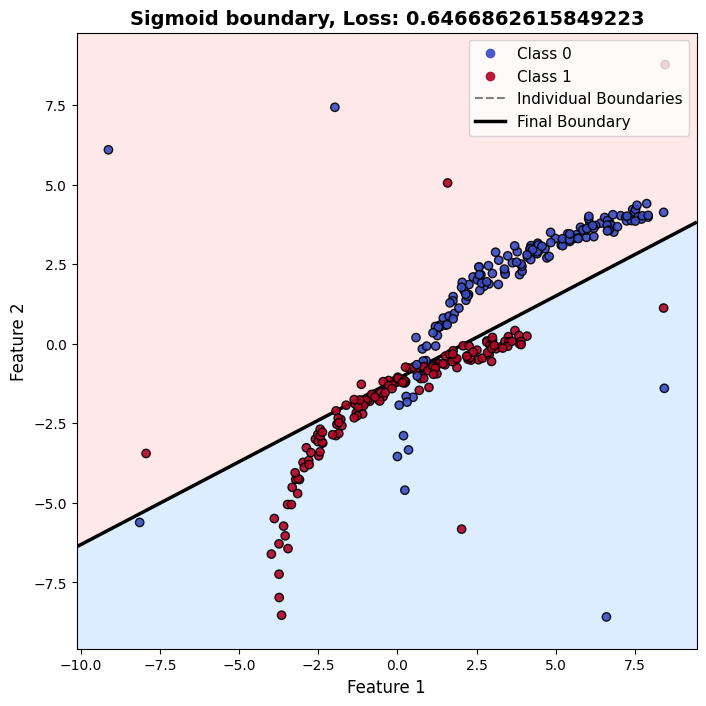

In [51]:
# Using backpropagation calculate weight adjustment 
# 1. Forward pass (calculate predictions which is also activations)
a = y_predicted = np.array([sigmoid_activation(sigmoid_w1, sigmoid_w2, _x1, _x2, sigmoid_b) for _x1, _x2 in X_data])

# 2. Calculate loss to activation:
L = binary_cross_entropy(y_data, y_predicted)

# 3. Calculate derivative loss to activation dL/da  
dL_da = (a - y_data) / (a * (1 - a))

# 4. Derivative of Activation w.r.t. Linear Sum (da/dz): This remains unchanged. The derivative of the sigmoid function is:
da_dz = a * (1 - a)

# 5. Calculate gradients for weights
dL_dw1 = (a - y_data) * X_data[:, 0]
dL_dw2 = (a - y_data) * X_data[:, 1]
dL_db = a - y_data

delta_w1 = np.sum(dL_dw1)
delta_w2 = np.sum(dL_dw2)
delta_b = np.sum(dL_db)

print(f"Binary cross-entropy loss: {L}")
print(f"Weight adjustments: dw1: {delta_w1}, dw2: {delta_w2}, db: {delta_b}")

plot_decision_boundary(X_data, y_data,
                       decision_functions=[sigmoid_boundary(sigmoid_w1, sigmoid_w2, sigmoid_b, 0.5)],
                       title=f"Sigmoid boundary, Loss: {L}",
                       swap_regions=True)  # Set the flag to swap sides

## Experiments and task examples

Do your experiments here

# Conclusions on work